In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pytz
import datetime 
import astral
import astropy.time as aptime
from scipy import stats
from scipy import optimize
import os
import time

%matplotlib inline
from matplotlib import rc
from matplotlib import rcParams
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15)

rc('axes', labelsize=20) 
rc('axes', linewidth=2)

rcParams['axes.titlesize'] = 15
rcParams['legend.fontsize'] = 15
rcParams['patch.linewidth'] = 1
#rcParams['axes.titlepad'] = 30
rcParams['axes.labelpad'] = 10

savedir = os.environ["HOME"]+'/Dropbox (GPI)/TEST_SCRATCH/scratch/mtallis/plots/SPIE_poster_figs/'
dstr = time.strftime('%Y%m%d')

# Load data

raw contrast data

In [2]:
csv_file1 = pd.read_csv('IFS_RawContrast_Gemini_env_20180530_all_seeing.csv')
csv_file1_copy = copy.copy(csv_file1)
raw_contrast_data= pd.DataFrame(csv_file1_copy)
print len(raw_contrast_data)

#  Create colums with datetimes and make them timezone aware
raw_contrast_data['dts'] = pd.to_datetime(raw_contrast_data['dts'])
raw_contrast_data['dts']=raw_contrast_data['dts'].dt.tz_localize(pytz.UTC)
raw_contrast_data['wfe_sq'] = raw_contrast_data['cal_wfe']**2

1274


KeyError: 'dts'

In [19]:
print sum(~np.isfinite(raw_contrast_data['MASSTAU']))
print sum(~np.isfinite(raw_contrast_data['DIMMSEE']))

17971
12356


environmental data

In [3]:
txt_file1 = pd.read_csv('GS_env_20180625.csv')
txt_file1_copy = copy.copy(txt_file1)
GS_env_data= pd.DataFrame(txt_file1_copy)
print len(GS_env_data)

GS_env_data['dts'] = aptime.Time(GS_env_data['MJDOBS'], format='mjd').datetime 
GS_env_data['dts'] = GS_env_data['dts'].dt.tz_localize(pytz.UTC)

txt_file2 = pd.read_csv('GS_env_20180601_night.csv')
txt_file2_copy = copy.copy(txt_file2)
GS_env_data_night= pd.DataFrame(txt_file2_copy)
print len(GS_env_data_night)

GS_env_data_night['dts'] = aptime.Time(GS_env_data_night['MJDOBS'], format='mjd').datetime 
GS_env_data_night['dts'] = GS_env_data_night['dts'].dt.tz_localize(pytz.UTC)

128632
64549


final contrast data

In [4]:
csv_file2 = pd.read_csv('IFS_FinalContrast_20180530.csv')
csv_file2_copy = copy.copy(csv_file2)
final_contrast_data= pd.DataFrame(csv_file2_copy)
print len(final_contrast_data)

#  Create colums with datetimes and make them timezone aware
final_contrast_data['dts'] = pd.to_datetime(final_contrast_data['dts'])
final_contrast_data['dts']=final_contrast_data['dts'].dt.tz_localize(pytz.UTC)

398


# Set conditions to data

In [5]:
def filter_data(data, imag = 7., tau = 1., see = 2., all_cond = True):
    "This selects all rows of input dataframe that satisfy conditions set by the user"
    
    date1 = datetime.date(year = 2014, month = 1, day =1)
    
    #  AO system requirements
    cond1 = data['dts'] > date1 
    cond2 = data['COADDS'] == 1
    cond3 = (data['OBSMODE'] == 'H_coron')|(data['OBSMODE'] == 'Spec')
    cond4 = data['AOFRAMES'] == 1000

    #  Good seeing conditions
    cond5 = data['IMAG'] < imag #Bright Stars
    cond6 = data['MASSTAU'] > tau  # slow moving turbulence [ms]
    cond7 = data['DIMMSEE'] < see  # smaller scale turbulence ["]
    
    if all_cond:
        ind = np.where(cond1 & cond2 & cond3 & cond4 & cond5 & cond6 & cond7)[0]  
        print len(ind)
    else:
        ind = np.where(cond1 & cond2 & cond3 & cond4 & cond5)[0]  
        print len(ind)

    filtered_data = data.iloc[ind]
    #filtered_data = filtered_data.dropna(subset = ['CONTR040','cal_wfe','M1_avg','TAMBIENT','Outside_OE_temperature'])
    
    new_ind = np.arange(len(filtered_data))
    filtered_data = filtered_data.set_index(new_ind)
        
    return filtered_data

In [6]:
r = filter_data(raw_contrast_data,imag = 7)
f = filter_data(final_contrast_data,imag=7)

2521
90


In [7]:
r

,DATAFILE,DATALAB,OBJNAME,DATESTR,UTSTART,MJDOBS,ITIME,COADDS,OBSMODE,DISPERSR,...,time_from_sunrise,hours_from_sunrise,night_number,OE_Interior_Air_temperature_dT,OMSS_AO_Bench_temperature_dT,OMSS_Interface_Structure_temperature_dT,OMSS_Mounting_Frame_temperature_dT,Outside_OE_temperature_dT,OMSATEMP_dT,wfe_sq
0,S20141109S0162.fits,GS-2014B-Q-500-1937-007,HR 826,141109,04:05:52.125,56970.171272,59.64639,1,H_coron,PRISM,...,0 days 18:29:40.866240000,18.494444,1.0,8.291149e-03,NaN,7.752973e-02,1.656898e-01,-1.547316e+00,0.208027,6186.561832
1,S20141109S0163.fits,GS-2014B-Q-500-1937-008,HR 826,141109,04:07:08.843,56970.172159,59.64639,1,H_coron,PRISM,...,0 days 18:30:57.520321000,18.515833,1.0,1.143997e-02,NaN,7.864173e-02,1.520954e-01,-1.431460e+00,0.212312,6236.355664
2,S20141109S0164.fits,GS-2014B-Q-500-1937-009,HR 826,141109,04:08:27.359,56970.173067,59.64639,1,H_coron,PRISM,...,0 days 18:32:15.980160000,18.537500,1.0,1.462975e-02,NaN,7.957224e-02,1.385877e-01,-1.319125e+00,0.216432,6611.560032
3,S20141109S0165.fits,GS-2014B-Q-500-1937-010,HR 826,141109,04:09:44.343,56970.173959,59.64639,1,H_coron,PRISM,...,0 days 18:33:33.057600000,18.559167,1.0,1.773060e-02,NaN,8.028178e-02,1.257191e-01,-1.214925e+00,0.220220,7340.616871
4,S20141109S0166.fits,GS-2014B-Q-500-1937-011,HR 826,141109,04:11:02.265,56970.174860,59.64639,1,H_coron,PRISM,...,0 days 18:34:50.921280000,18.580556,1.0,2.083014e-02,NaN,8.079269e-02,1.131226e-01,-1.115857e+00,0.223783,7564.372308
5,S20141109S0167.fits,GS-2014B-Q-500-1937-012,HR 826,141109,04:12:19.265,56970.175752,59.64639,1,H_coron,PRISM,...,0 days 18:36:07.990080000,18.601944,1.0,2.386545e-02,NaN,8.109461e-02,1.010542e-01,-1.023932e+00,0.227051,8244.022572
6,S20141109S0168.fits,GS-2014B-Q-500-1937-013,HR 826,141109,04:13:37.250,56970.176654,59.64639,1,H_coron,PRISM,...,0 days 18:37:25.896960000,18.623611,1.0,2.690081e-02,NaN,8.119379e-02,8.925832e-02,-9.372063e-01,0.230090,8362.114869
7,S20141109S0176.fits,GS-2014B-Q-500-1937-021,HR 826,141109,04:33:17.437,56970.190314,59.64639,1,H_coron,PRISM,...,0 days 18:57:07.095040000,18.951944,1.0,6.882971e-02,NaN,5.735812e-02,-3.977264e-02,-3.858559e-01,0.243828,18325.280567
8,S20141109S0177.fits,GS-2014B-Q-500-1937-022,HR 826,141109,04:34:34.859,56970.191210,59.64639,1,H_coron,PRISM,...,0 days 18:58:24.552640000,18.973333,1.0,7.131562e-02,NaN,5.413139e-02,-4.498283e-02,-3.996918e-01,0.242610,21930.026126
9,S20141110S0032.fits,GS-2014B-Q-500-1861-030,AU Mic,141110,00:34:36.562,56971.024552,59.64639,1,H_coron,PRISM,...,0 days 14:59:04.336000000,14.984444,2.0,-1.832479e-01,NaN,-1.421080e-01,-1.445301e-01,-7.254396e-01,-0.038222,9746.921802


# Select floor of data

In [7]:
def floor(data,parval = 'cal_wfe', percent = .25, temp1 = 'M1_avg', temp2 = 'TAMBIENT',temp3 ='',binedges = 'auto'):
    "Select points below a percentile"
    
    if temp3 != '':
        mask = (data.loc[:,temp3] < .6) & (data.loc[:,temp3] > -.6) & (data.loc[:,temp3] != 0)
        data = data[mask]
        x = pd.to_numeric(data[temp3],errors = 'coerce')
    else:
        x = data[temp1] - data[temp2]
    
    # compute bins
    numdat, binedges = np.histogram(x, bins = binedges) 
    data['bin'] = np.digitize(x, binedges)
    
    # dataframe containing rows with floor points 
    df_floor = data.groupby(by ='bin').apply(lambda x: x.loc[x[parval] <= x[parval].quantile(percent)])
    
    return df_floor

In [8]:
r_floor = floor(r, percent = .1)

# Scatter plot

In [9]:
def find_offset(data, temp1 = 'M1_avg', temp2 = 'T_twr', parval = 'cal_wfe'):
    
    #  Define the x and y data  
    offset = np.linspace(-2,2, 1000)
    x = np.abs(data[temp1][None,:] - data[temp2][None,:] + offset[:,None])
    y = data[parval]
    
    if parval != 'cal_wfe':
        y = np.log10(data[parval])
        
    result = [np.round(stats.linregress(r,y),3) for r in x]
    slopes, intercepts, r_values, p_values, stderrs = zip(*result)
    r2 = [ r**2 for r in r_values]
    idx = np.argmax(r2)
    
    return offset[idx], result[idx]
    

In [10]:
def plot_fit(ax,data,temp1 = 'M1_avg', temp2 = 'T_twr',parval = 'CONTR040', offset = 0, b = 'auto',col = plt.cm.Blues_r(0)):
    
    def func(x,a,b,c):
        return a*x**2 + b*x + c
    
    x = data[temp1] - data[temp2] + offset
    y = data[parval]
    
    n, nbins = np.histogram(x, bins = b) 
    data['bin'] = np.digitize(x, nbins,right=True)

    bin_cent = (nbins[1:] + nbins[:-1])/2
    sumy,binedges = np.histogram(x, nbins, weights=y)
    sumy2,binedges = np.histogram(x, nbins, weights=y*y)
    bin_means = sumy/n
    bin_std = np.sqrt(sumy2/n - bin_means*bin_means)
    #biny = data.groupby(by = 'bin')[parval].mean()
    #bin_std = data.groupby(by = 'bin')[parval].std()
    
    popt,pcov = optimize.curve_fit(func,bin_cent,bin_means,sigma = bin_std, absolute_sigma = True)
    print popt
    
    x_fit = np.linspace(-5,7,1200)
    m = func(x_fit,*popt)
    
    out = ax.plot(x_fit,m,color = col,lw=3)
    
    if parval == 'wfe_sq':
        print(np.sqrt(func(4,*popt))-np.sqrt(func(0,*popt)))
        
    else:
        print(func(4,*popt)/func(0,*popt))
    
    return out   

In [11]:
def plot_linear_fit(ax,data,col,temp1 = 'M1_avg', temp2 = 'TAMBIENT',temp3 ='', parval = 'cal_wfe', offset = 0):
    
    #  select x data to fit
    if temp3 != '':
        mask = (data.loc[:,temp3] < .6) & (data.loc[:,temp3] > -.6) & (data.loc[:,temp3] != 0)
        data = data[mask]
        x = pd.to_numeric(data[temp3],errors = 'coerce')
    else:
        x = np.abs(data[temp1] - data[temp2] + offset)
    
    #  select y data to fit
    if (parval == 'CONTR040')|(parval == 'C40_CH4_scaled'):
        y = np.log10(data[parval])
        
        def func(x, m, i):
            return 10**(x*m+i)
    else:
        y = data[parval]
        def func(x, m, i):
            return x*m+i
    
    # Do a linear regression fit
    slope, intercept, r_value, p_value, stderr = stats.linregress(x,y)
    x_fit = np.linspace(-4,7,1100)
    y_fit = func(x_fit, slope, intercept)
    
    print('slope: ',(slope))
    print('err: ', stderr)
    print('intercept: ', intercept)
    print('r2: ', r_value**2)
    
    out = ax.plot(x_fit,y_fit,color = col,lw=2)
    return out
    

In [12]:
def scatter_plot(ax, data, color = False, parval1 = 'cal_wfe', temp1 = 'M1_avg', temp2 = 'TAMBIENT',
                 temp3 = '', size = 10, parval2 = 'MASSTAU', absolute = False, offset = 0,alph = .2,
                 col = 'navy',mar = 'o',cm =plt.cm.Blues ):
    
    ## x - axis is temperature rate of change, temperature difference, or absolute temperature difference
    if temp3 != '':
        mask = (data.loc[:,temp3] < .6) & (data.loc[:,temp3] > -.6) & (data.loc[:,temp3] != 0)
        data = data[mask]
        x = data[temp3]
        ax.set_xlabel(r'AO bench temperature drift rate  $[\frac{C^\circ}{hr}]$')
        ax.set_xlim(-.6,.6)
        
    else:
        x = data[temp1] - data[temp2]
        ax.set_xlabel('Primary - Outside air [$C^\circ$]')

    if absolute: 
        x = np.abs(x + offset)
        ax.set_xlabel('|Primary - Outside air| [$C^\circ$]')
        ax.set_xlim(-1,x.max()+1.)
   
    y = data[parval1]
    
    if parval1 == 'cal_wfe':
        ax.set_ylabel('Residual WFE [RMS nm]')
        #out = ax.scatter(x,y,c='k',s = size)
    
    ## y - axis either log scale  or not
    if parval1 == 'CONTR040':
        ax.set_ylabel('Raw 5-$\sigma$ contrast')
        #ax.set_yscale('log',basey=10)
        #ax.set_ylim(10**-4.7,10**-2.8)
        #out = ax.scatter(x,y,c='k',s = size)

    if parval1 == 'C40_CH4_scaled':
        ax.set_ylabel('Final 5-$\sigma$ contrast')
        #ax.set_yscale('log',basey=10)
        #ax.set_ylim(10**-5.7,10**-4.7)
        #out = ax.scatter(x,y,c='k',s = size,marker = 's')

    ## Plot a third variable as color of points    
    if color:
        n = data[parval2]
        out = ax.scatter(x,y,c=n,cmap=cm,marker = mar,lw=.5,s=size,alpha = .5)
    else:
        out = ax.scatter(x,y,c=col,s = size,marker = mar,alpha = alph)
    
    return out   


# 24 hr plot

In [25]:
GS_env_data['hour'] = np.round(GS_env_data['hours_from_sunset'])

In [36]:
def plot_med_temp_over_time(ax,data,interval = 'hour',  mean = True, sensors = [], drift_rate = False,
                            temp = 'OMSS_AO_Bench_temperature_dT'):
    
    if drift_rate == True:
        if mean:
            m = data.groupby(by = interval)[temp].mean()
        else:
            m = data.groupby(by = interval)[temp].median()

        ax.plot(m.index,m,'o-', color = 'cornflowerblue')
    
        # plot labels 
        ax.set_ylabel(r'AO bench temp drift rate  $[\frac{C^\circ}{hr}]$')
        ax.set_xticks(np.linspace(0,24,13))
        #ax.grid(axis='y', alpha = .5)
        ax.legend(loc=4,frameon=False)
    
    else:
        #ax.set_color_cycle([plt.cm.magma_r(i) for i in np.linspace(0, 1, 4)])

        labels = ['AO bench','Dome air','Primary','Outside air']
        colors = ['grey','red','k','darkorange',]
        fmt = ['-.','-','-','-.'] 
        i = 0
    
        for s in sensors:
            if mean:
                m = data.groupby(by = interval)[str(s)].mean()
                std = data.groupby(by = interval)[str(s)].std()
                q1 = m-std
                q3 = m+std
            else:
                m = data.groupby(by = interval)[str(s)].median()
                q1 =  data.groupby(by = interval)[str(s)].quantile(.25)
                q3 =  data.groupby(by = interval)[str(s)].quantile(.75)
                
            ax.plot(m.index,m,fmt[i], label = labels[i],lw = 3,color = colors[i])
            #ax.fill_between(m.index, q1, q3, facecolor=colors[i], alpha=0.5,label='envelope')
            ax.set_ylabel('Median Temperature [$C^\circ$]')

            i = i + 1
    
    # plot labels 
    ax.set_xlabel('Hours after sunset')
    ax.set_xticks(np.linspace(0,24,13))
    #ax.grid(axis='y', alpha = .5)
    ax.legend(labels,loc=3,frameon=False,ncol=2)
    
    return

# Histogram plot

In [166]:
def histogram(ax,data,temp1 = 'M1_avg', temp2 = 'T_twr', temp3 = 'dome_low',temp4 = 'OMSS_AO_Bench_temperature', bins = 'auto'):
    
    n_bins = bins
    x = (data[temp1] - data[temp2]).dropna()
    y = (data[temp3]- data[temp2]).dropna()
    z = (data[temp4]- data[temp2]).dropna()
    
    ax.hist(x, n_bins, normed=True , stacked=True, color = 'k',alpha=.2)
    ax.hist(y, n_bins, normed=True , stacked=True, color = 'b',alpha=.2)
    #ax.hist(z, n_bins, normed=True , stacked=True, color = 'royalblue',alpha=.2)


    ax.set_ylabel('Normalized Counts')
    ax.set_xlabel('Temperature Difference [$C^\circ$]')
    ax.legend(['Primary - Outside air','Dome air - Outside air'],fontsize=15, frameon = False)
    ax.set_xlim(-5,10)

    return

In [164]:
night_number= GS_env_data.groupby(by='night_number')
range_temp = (night_number['T_twr'].max() - night_number['T_twr'].min()).dropna()

<IPython.core.display.Javascript object>


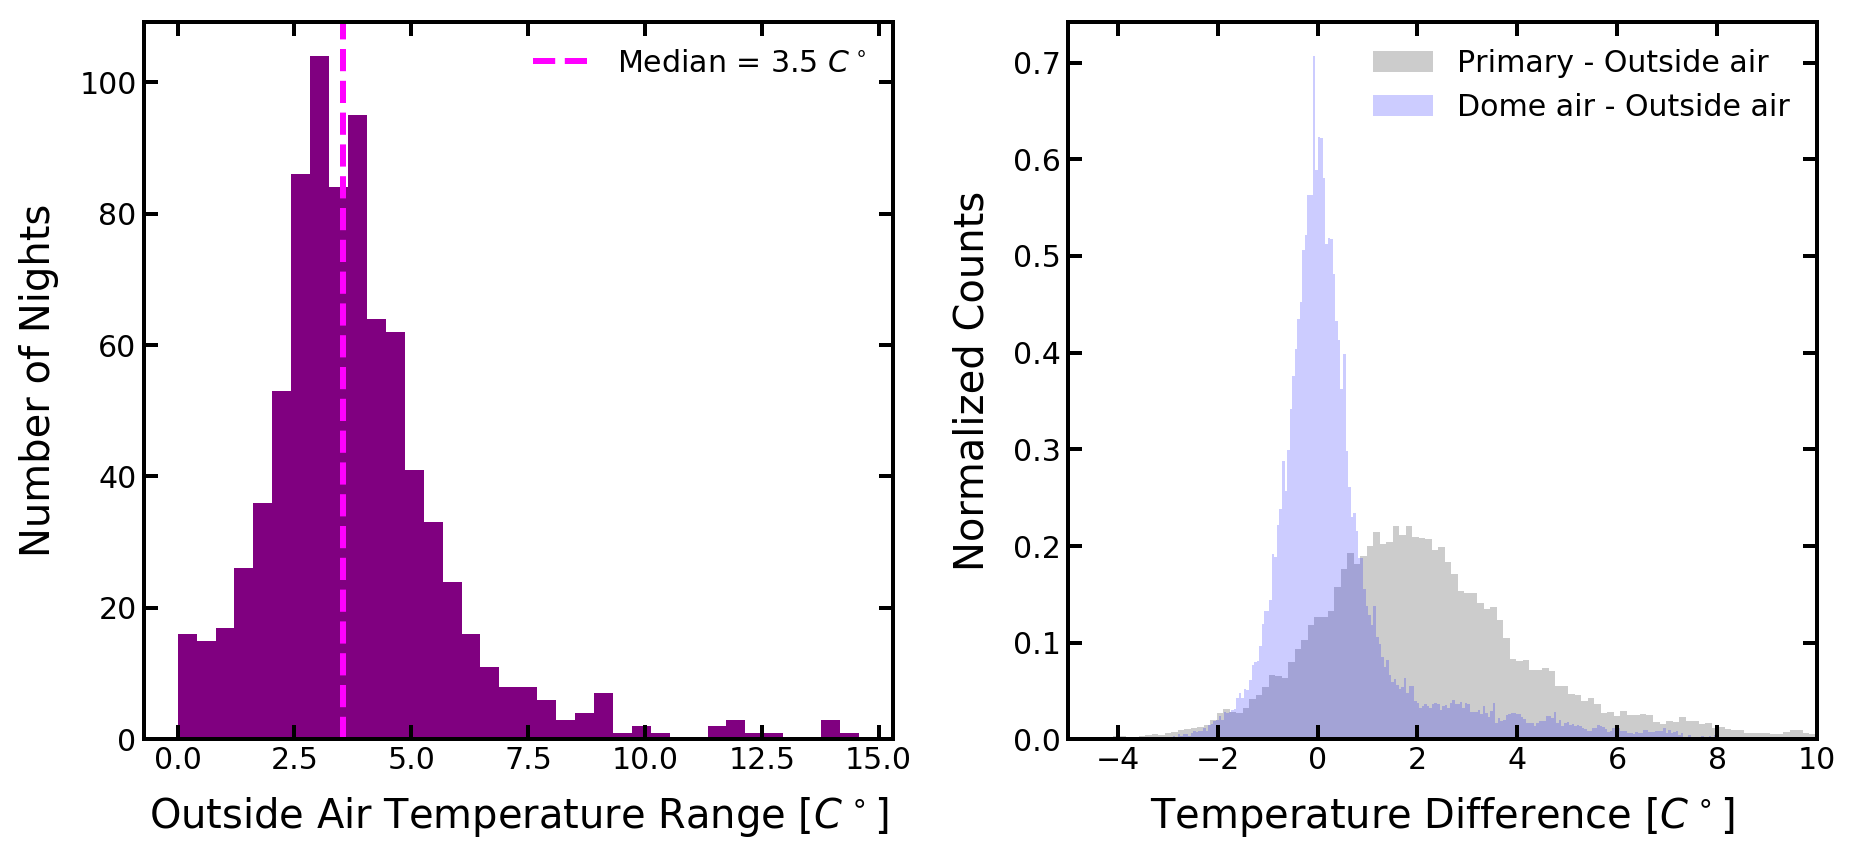

In [180]:
%matplotlib notebook

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols =2, figsize=(13,6))

ax1.hist(range_temp,bins='auto',color='purple')
ax1.set_ylabel('Number of Nights')
ax1.set_xlabel('Outside Air Temperature Range [$C^\circ$]')
ax1.tick_params(axis='both',which = 'both',direction='in', width=2,top=True,right=True)
ax1.axvline(x = range_temp.median(),linestyle = '--',color = 'magenta',linewidth=3)
ax1.legend(['Median = 3.5 $C^\circ$'],fontsize=15, frameon = False)

hist = histogram(ax2,GS_env_data_night,bins = 'auto')
ax2.tick_params(axis='both',which = 'both',direction='in', width=2,top=True,right=True)


fig.tight_layout()       

plt.savefig(savedir+'out_temp_hist_'+dstr+'.png',dpi = 300)



# Fig 2. Histogram & Temperature over time 

<IPython.core.display.Javascript object>


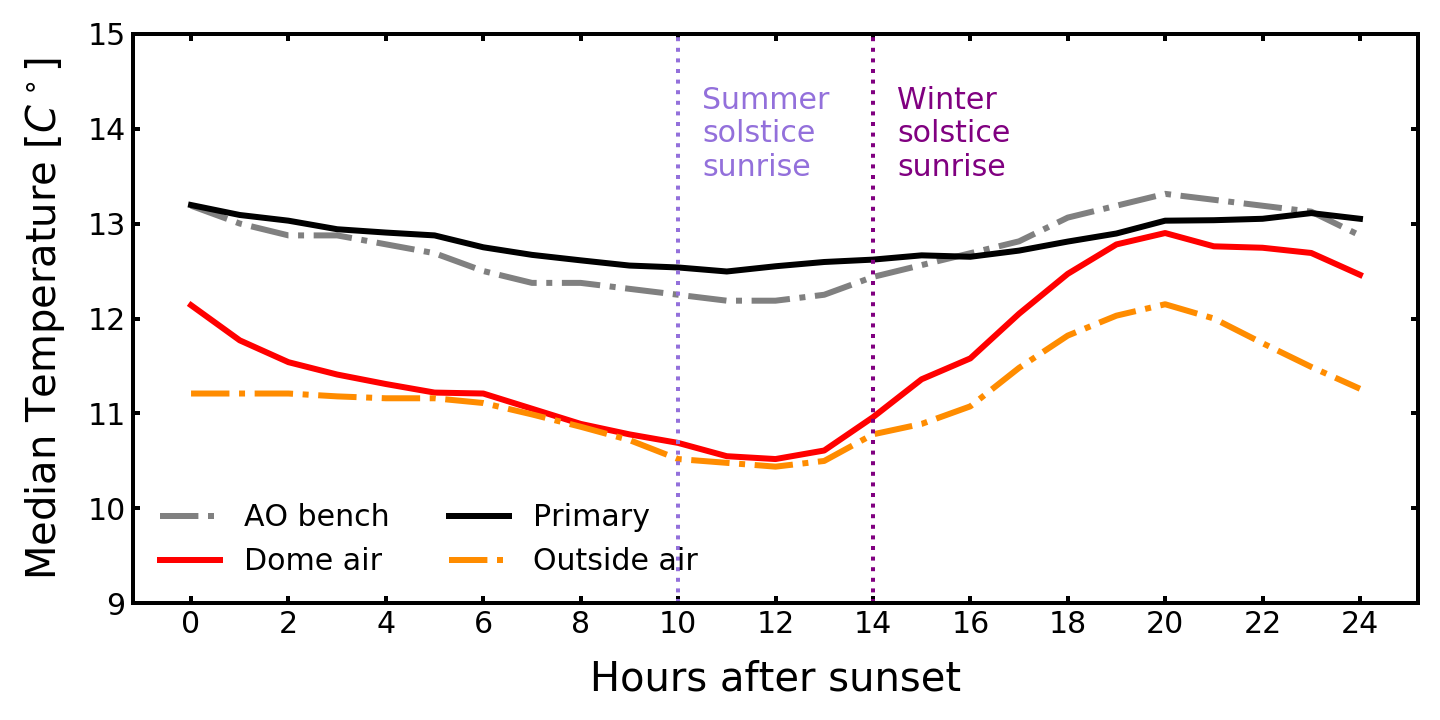

In [38]:
% matplotlib notebook

g = GS_env_data.groupby(['night_number'])

fig,ax2 = plt.subplots(1,1,figsize = [10,5])

#fig,(ax1,ax2) = plt.subplots(1,2,figsize = [12,4],gridspec_kw = {'width_ratios':[1.2, 2]})
#hist = histogram(ax1,GS_env_data_night,bins = 'auto')
t24 = plot_med_temp_over_time(ax2,GS_env_data,sensors = ['OMSS_AO_Bench_temperature','dome_low','M1_avg','T_twr'],mean = False)
ax2.tick_params(axis='both',which = 'both',direction='in', width=2,top=True,right=True)

#sunsets
ax2.axvline(x=10,linestyle = ':',color = 'mediumpurple',linewidth = 2)

#sunrise
ax2.axvline(x=14,linestyle = ':',color = 'purple',linewidth = 2)

ax2.annotate('Summer \nsolstice\nsunrise',[10.5,13.5],fontsize =15,color = 'mediumpurple')
#ax2.axvline(x=5,linestyle = ':',color = 'skyblue')
ax2.annotate('Winter \nsolstice\nsunrise',[14.5,13.5],fontsize=15,color = 'purple')
ax2.set_ylim(9,15)

'''ax2.set_color_cycle([plt.cm.magma(i) for i in np.linspace(0, .75, 4)])

i = 0
for name, group in g:
    if name % 65 == 4:
        i = i+1
        ax2.plot(group.hours_from_sunset[:-1], group.M1_avg[:-1], alpha =.2,lw =1)
        ax2.plot(group.hours_from_sunset[:-1], group.T_twr[:-1], alpha =.2,lw =1)
        ax2.plot(group.hours_from_sunset[:-1], group.OMSS_AO_Bench_temperature[:-1], alpha =.2,lw =1)
'''
fig.tight_layout()       
plt.savefig(savedir+'24_hr_temp_hist_'+dstr+'.png',dpi = 300)



<IPython.core.display.Javascript object>


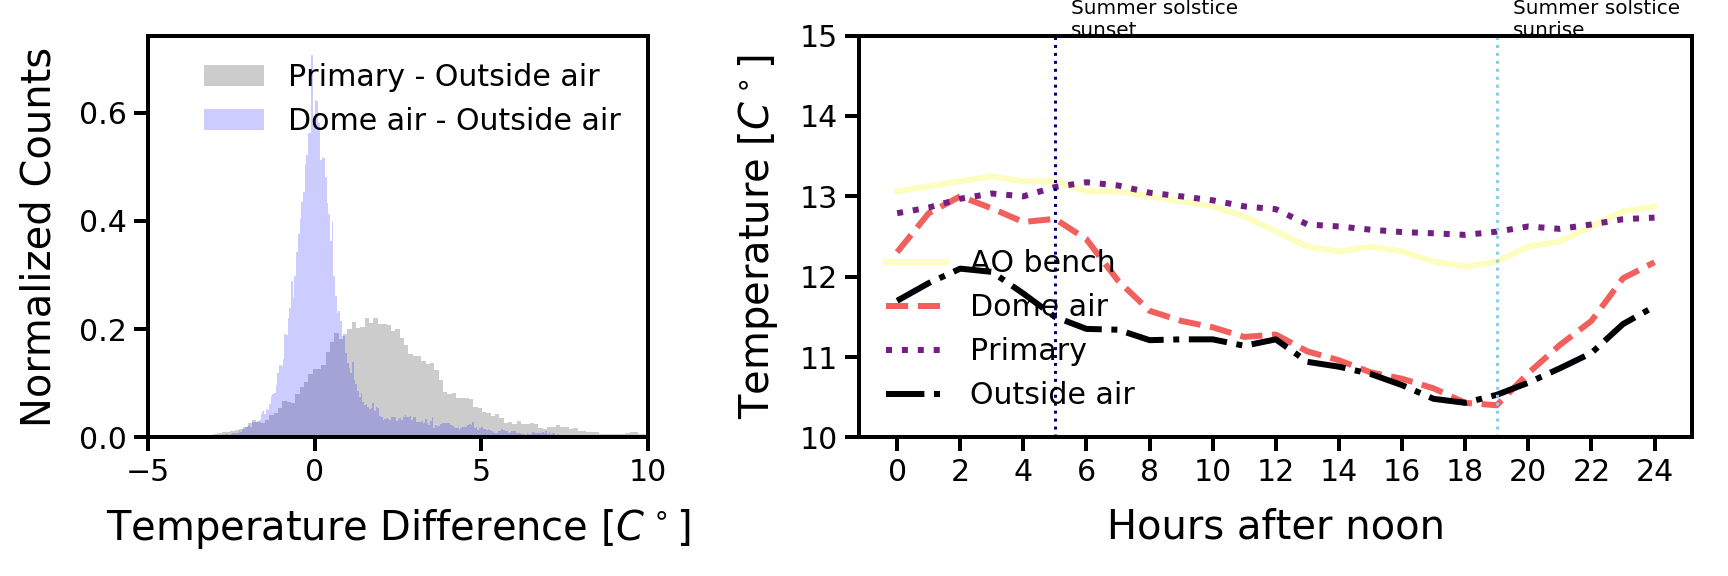

In [186]:
% matplotlib notebook

g = GS_env_data.groupby(['night_number'])

fig,(ax1,ax2) = plt.subplots(1,2,figsize = [12,4],gridspec_kw = {'width_ratios':[1.2, 2]})
hist = histogram(ax1,GS_env_data_night,bins = 'auto')
t24 = plot_med_temp_over_time(ax2,GS_env_data,sensors = ['OMSS_AO_Bench_temperature','dome_low','M1_avg','T_twr'],mean = False)
#ax2.set_color_cycle([plt.cm.Set1(i) for i in np.linspace(0, 1, 6)])

'''i = 0
for name, group in g:
    if name % 65 == 4:
        i = i+1
        ax2.plot(group.hours_from_sunset[:-1], group.M1_avg[:-1], alpha =.2,lw =1,color='k')
        ax2.plot(group.hours_from_sunset[:-1], group.T_twr[:-1], alpha =.2,lw =1,color='yellow')
        ax2.plot(group.hours_from_sunset[:-1], group.OMSS_AO_Bench_temperature[:-1], alpha =.2,lw =1,color='red')
        ax2.plot(group.hours_from_sunset[:-1], group.dome_low[:-1], alpha =.2,lw =1,color='purple')'''

#sunsets
ax2.axvline(x=5,linestyle = ':',color = 'navy')

#sunrise
ax2.axvline(x=19,linestyle = ':',color = 'skyblue')

ax2.annotate('Summer solstice\nsunset',[5.5,15])
#ax2.axvline(x=5,linestyle = ':',color = 'skyblue')
ax2.annotate('Summer solstice\nsunrise',[19.5,15])
ax2.set_ylim(10,15)

fig.tight_layout()       
#plt.savefig(savedir+'24_hr_temp_hist_'+dstr+'.png',dpi = 300)



# Fig 3. 4 raw & final contrasts vs. temp

In [94]:
r_cont_floor = floor(r,parval='CONTR040',percent=.01)
f_cont_floor = floor(f,parval='C40_CH4_scaled',percent=.01)

<IPython.core.display.Javascript object>


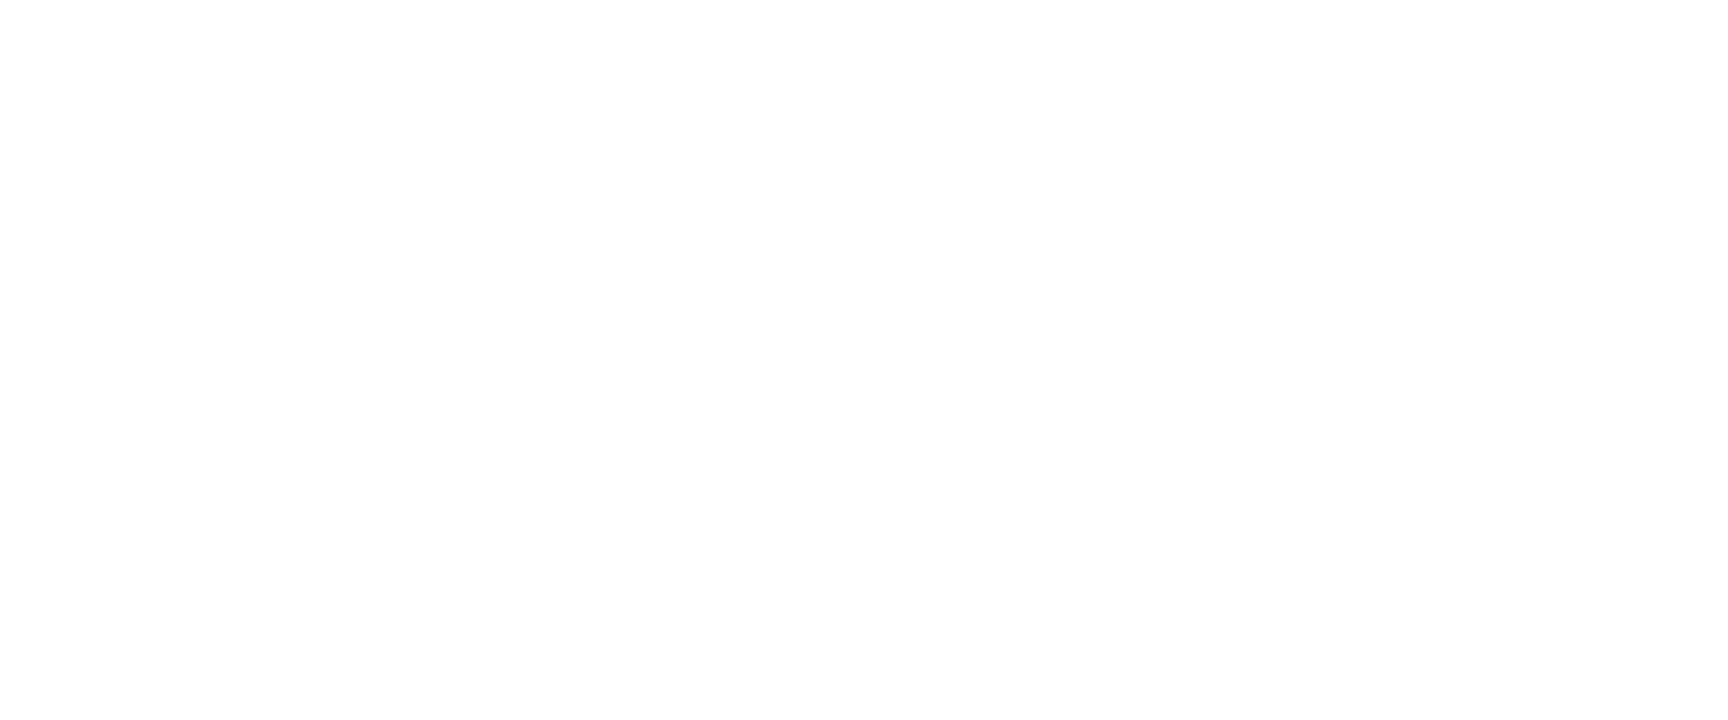

ERROR: NameError: name 'r' is not defined [IPython.core.interactiveshell]


NameError: name 'r' is not defined

In [23]:
%matplotlib notebook


fig,(ax1,ax2) = plt.subplots(nrows=1,ncols =2, figsize=(12,5))
im_r = scatter_plot(ax1,r,temp1 = 'M1_avg',parval1 = 'CONTR040',col = plt.cm.Blues_r(150),alph =.3,size=15)
fit_r = plot_fit(ax1,r_cont_floor,parval = 'CONTR040')
#ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
#ax1.set_ylim(10**-4.7,10**-3.3)
ax1.set_xlim(-4,5.5)
ax1.set_ylim(2*10**-5,11*10**-4)
ax1.set_yscale('log')
ax1.tick_params(axis='both',which = 'both',direction='in', width=2,top=True,right=True)



im_f = scatter_plot(ax2,f,temp1 = 'M1_avg',parval1 = 'C40_CH4_scaled',col = plt.cm.Blues_r(120),alph=1,size = 30)
fit_f = plot_fit(ax2,f_cont_floor,parval = 'C40_CH4_scaled')
#ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
ax2.set_ylim(2*10**-6.5,5*10**-5)
ax2.set_xlim(-4,5.5)
ax2.set_yscale('log')
ax2.tick_params(axis='both',which = 'both',direction='in', width=2,top=True,right=True)

fig.tight_layout()
fig.subplots_adjust(wspace=0.4)
#plt.savefig(savedir+'raw_final_M1_amb_floor_fit_'+dstr+'.png',dpi = 300)



<IPython.core.display.Javascript object>


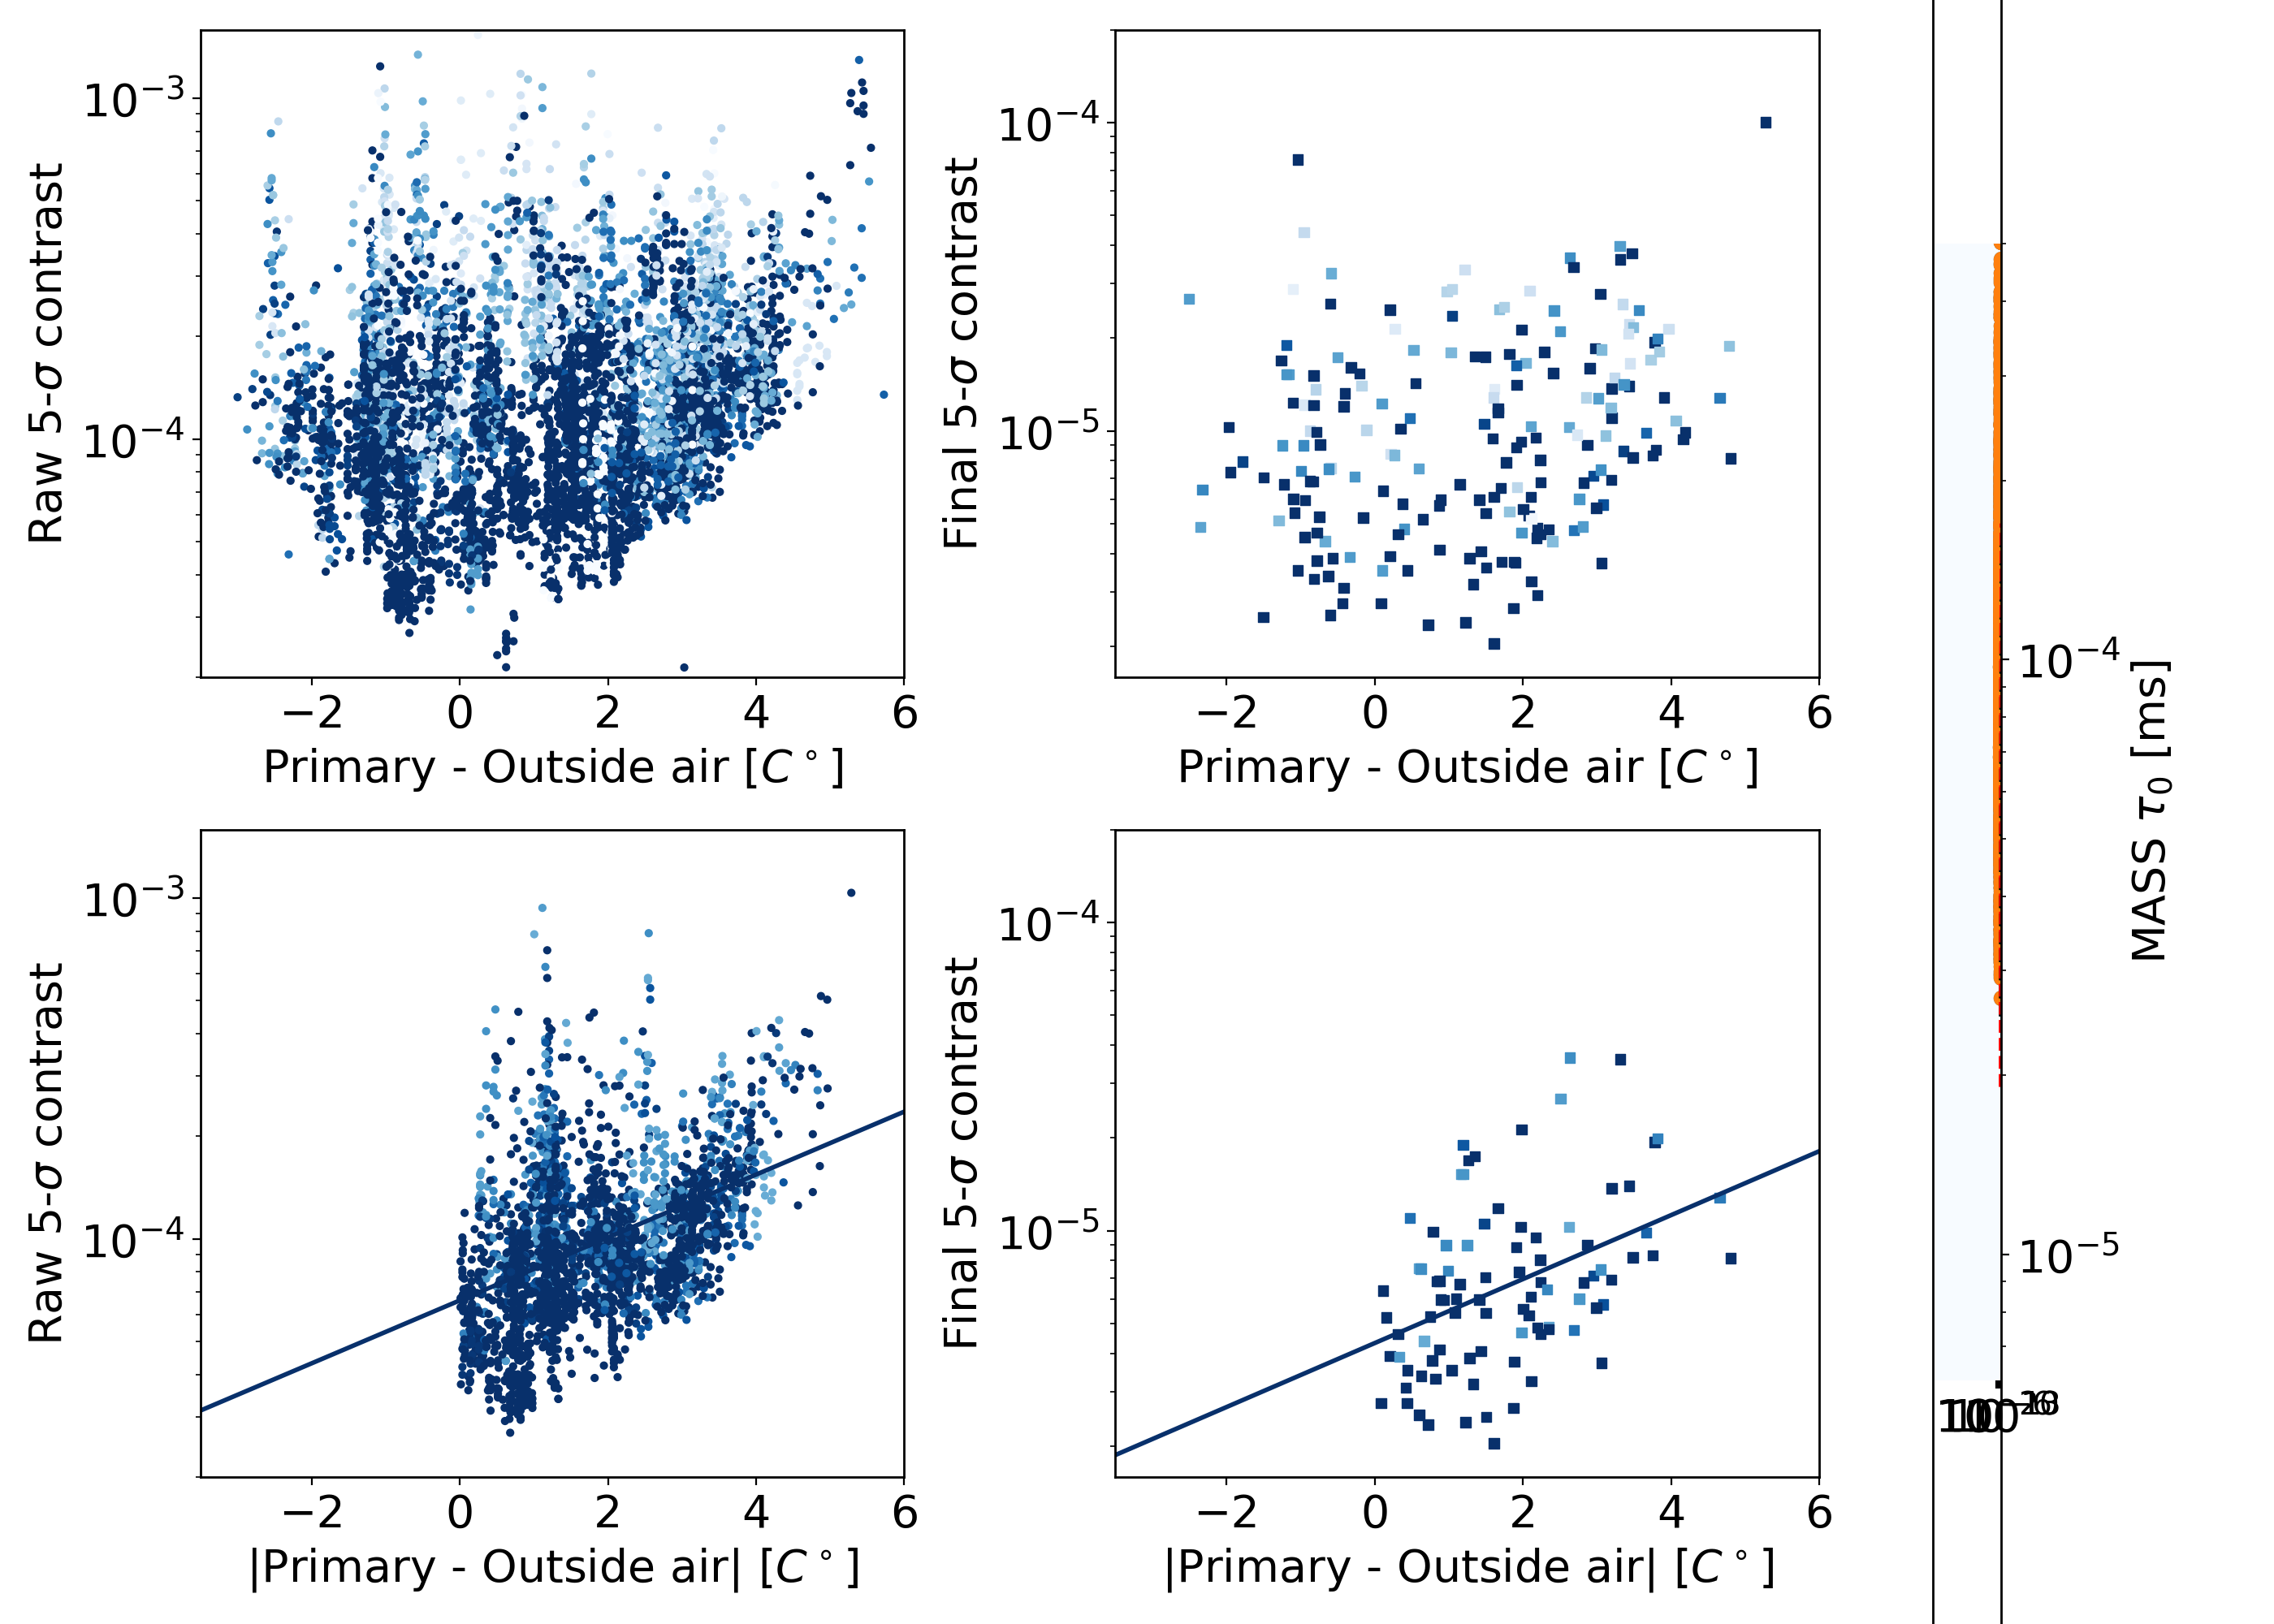

('slope: ', 0.0923226786509294)
('intercept: ', -4.180671262212823)
('r2: ', 0.1927917046985605)
('slope: ', 0.10371219376855233)
('intercept: ', -5.364411897772828)
('r2: ', 0.17577518041317222)


In [200]:
%matplotlib notebook

fig,((ax1, ax3), (ax2, ax4)) = plt.subplots(nrows=2,ncols =2, figsize=(14,10))

imr = scatter_plot(ax1,raw_contrast_data,temp1 = 'M1_avg',parval1 = 'CONTR040',parval2 = 'MASSTAU',color=True)
absr = scatter_plot(ax2,r,col = plt.cm.Blues_r(0),temp1 = 'M1_avg',parval1 = 'CONTR040',parval2 = 'MASSTAU',absolute=True,color = True)
fitr = plot_linear_fit(ax2,r,col = plt.cm.Blues_r(0),temp1 = 'M1_avg',parval = 'CONTR040')

absr.set_clim(.5,1.5)
imr.set_clim(.5,1.5)
ax1.set_xlim(-3.5,6)
ax2.set_xlim(-3.5,6)

imf = scatter_plot(ax3,final_contrast_data,temp1 = 'M1_avg',parval1 = 'C40_CH4_scaled',parval2 = 'MASSTAU',color=True,  mar = 's', size = 20)
absf = scatter_plot(ax4,f,col = plt.cm.Blues_r(0),temp1 = 'M1_avg',parval1 = 'C40_CH4_scaled',parval2 = 'MASSTAU',absolute=True,color = True,size = 20,  mar = 's')
fitf = plot_linear_fit(ax4,f,col = plt.cm.Blues_r(0),temp1 = 'M1_avg',parval = 'C40_CH4_scaled')

absf.set_clim(.5,1.5)
imf.set_clim(.5,1.5)
ax3.set_xlim(-3.5,6)
ax4.set_xlim(-3.5,6)

fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

fig.subplots_adjust(right=0.8)
#cbar = fig.add_axes([0.85, 0.57, 0.05, 0.41])
cbar = fig.add_axes([0.85, 0.15, 0.03, 0.7])

fig.colorbar(imr, cax=cbar,label=r'MASS $\tau_0$ [ms]')

plt.savefig(savedir+'raw_final_M1_tau_fit_'+dstr+'.png',dpi = 300)



# Fig 5. WFE fit 

In [29]:
r_wfe_floor = floor(r,parval='wfe_sq',percent=.01)

In [98]:
len(r_wfe_floor)

35

<IPython.core.display.Javascript object>


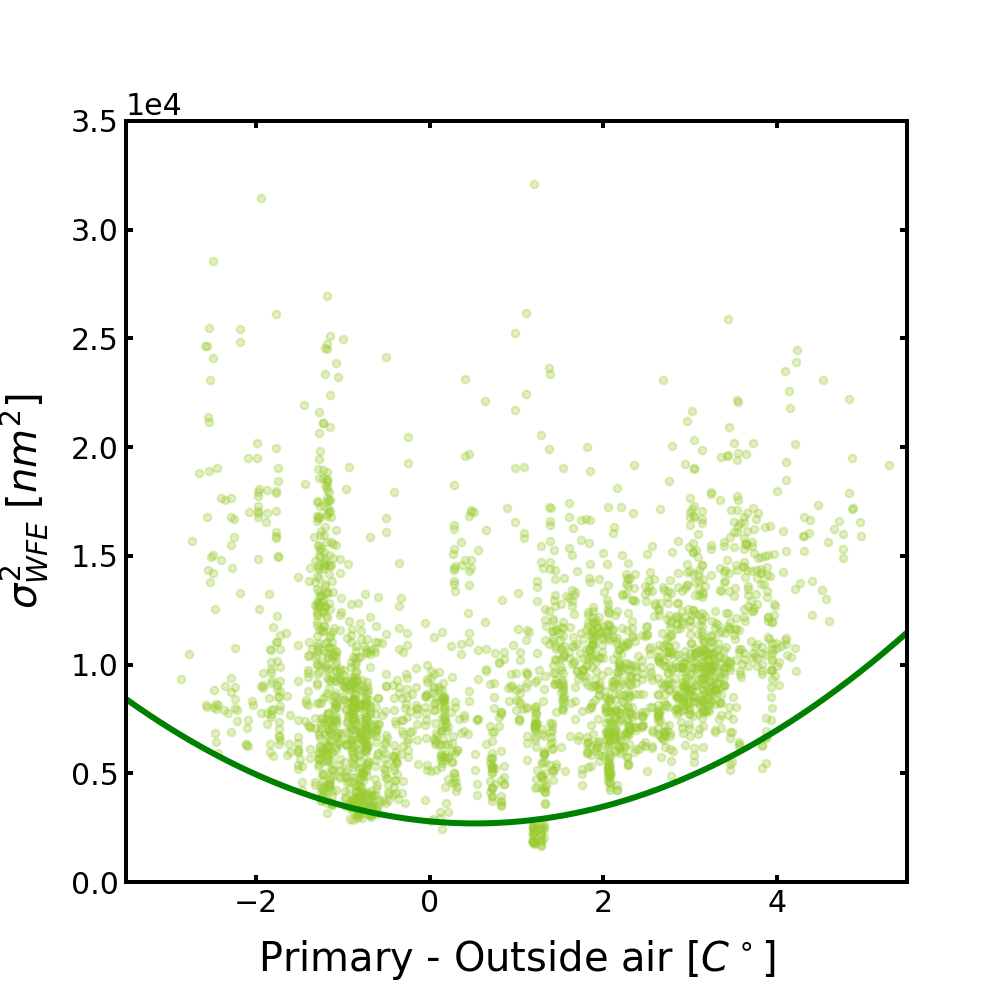

[ 354.09354063 -368.02997806 2789.52729039]
30.747796511666905


In [33]:
% matplotlib notebook

fig,ax = plt.subplots(1,1,figsize = [7,7])
im = scatter_plot(ax,r,temp1 = 'M1_avg',parval1 ='wfe_sq',col = 'yellowgreen',size = 15,alph = .3)
fit = plot_fit(ax,r_wfe_floor,temp1 = 'M1_avg',parval = 'wfe_sq',col = 'green',b = 6)
#im.set_clim(.5,1.5)

#fig.subplots_adjust(right=0.8)
#cbar = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar,label=r'MASS $\tau_0$ [ms]')



#ax.legend(['hello'],frameon=False)
ax.tick_params(axis='both',which = 'both',direction='in', width=2,top=True,right=True)
ax.set_xlim(-3.5,5.5)
ax.set_ylim(0,35000)
ax.set_ylabel('$\sigma_{WFE}^2$ $[nm^2]$')
ax.ticklabel_format(axis = 'y',style = 'sci',scilimits=(0,0))
#plt.savefig(savedir+'wfe_M1_ambient_fit_'+dstr+'.png',dpi = 300)



# Fig 6. Temperature drift

<IPython.core.display.Javascript object>


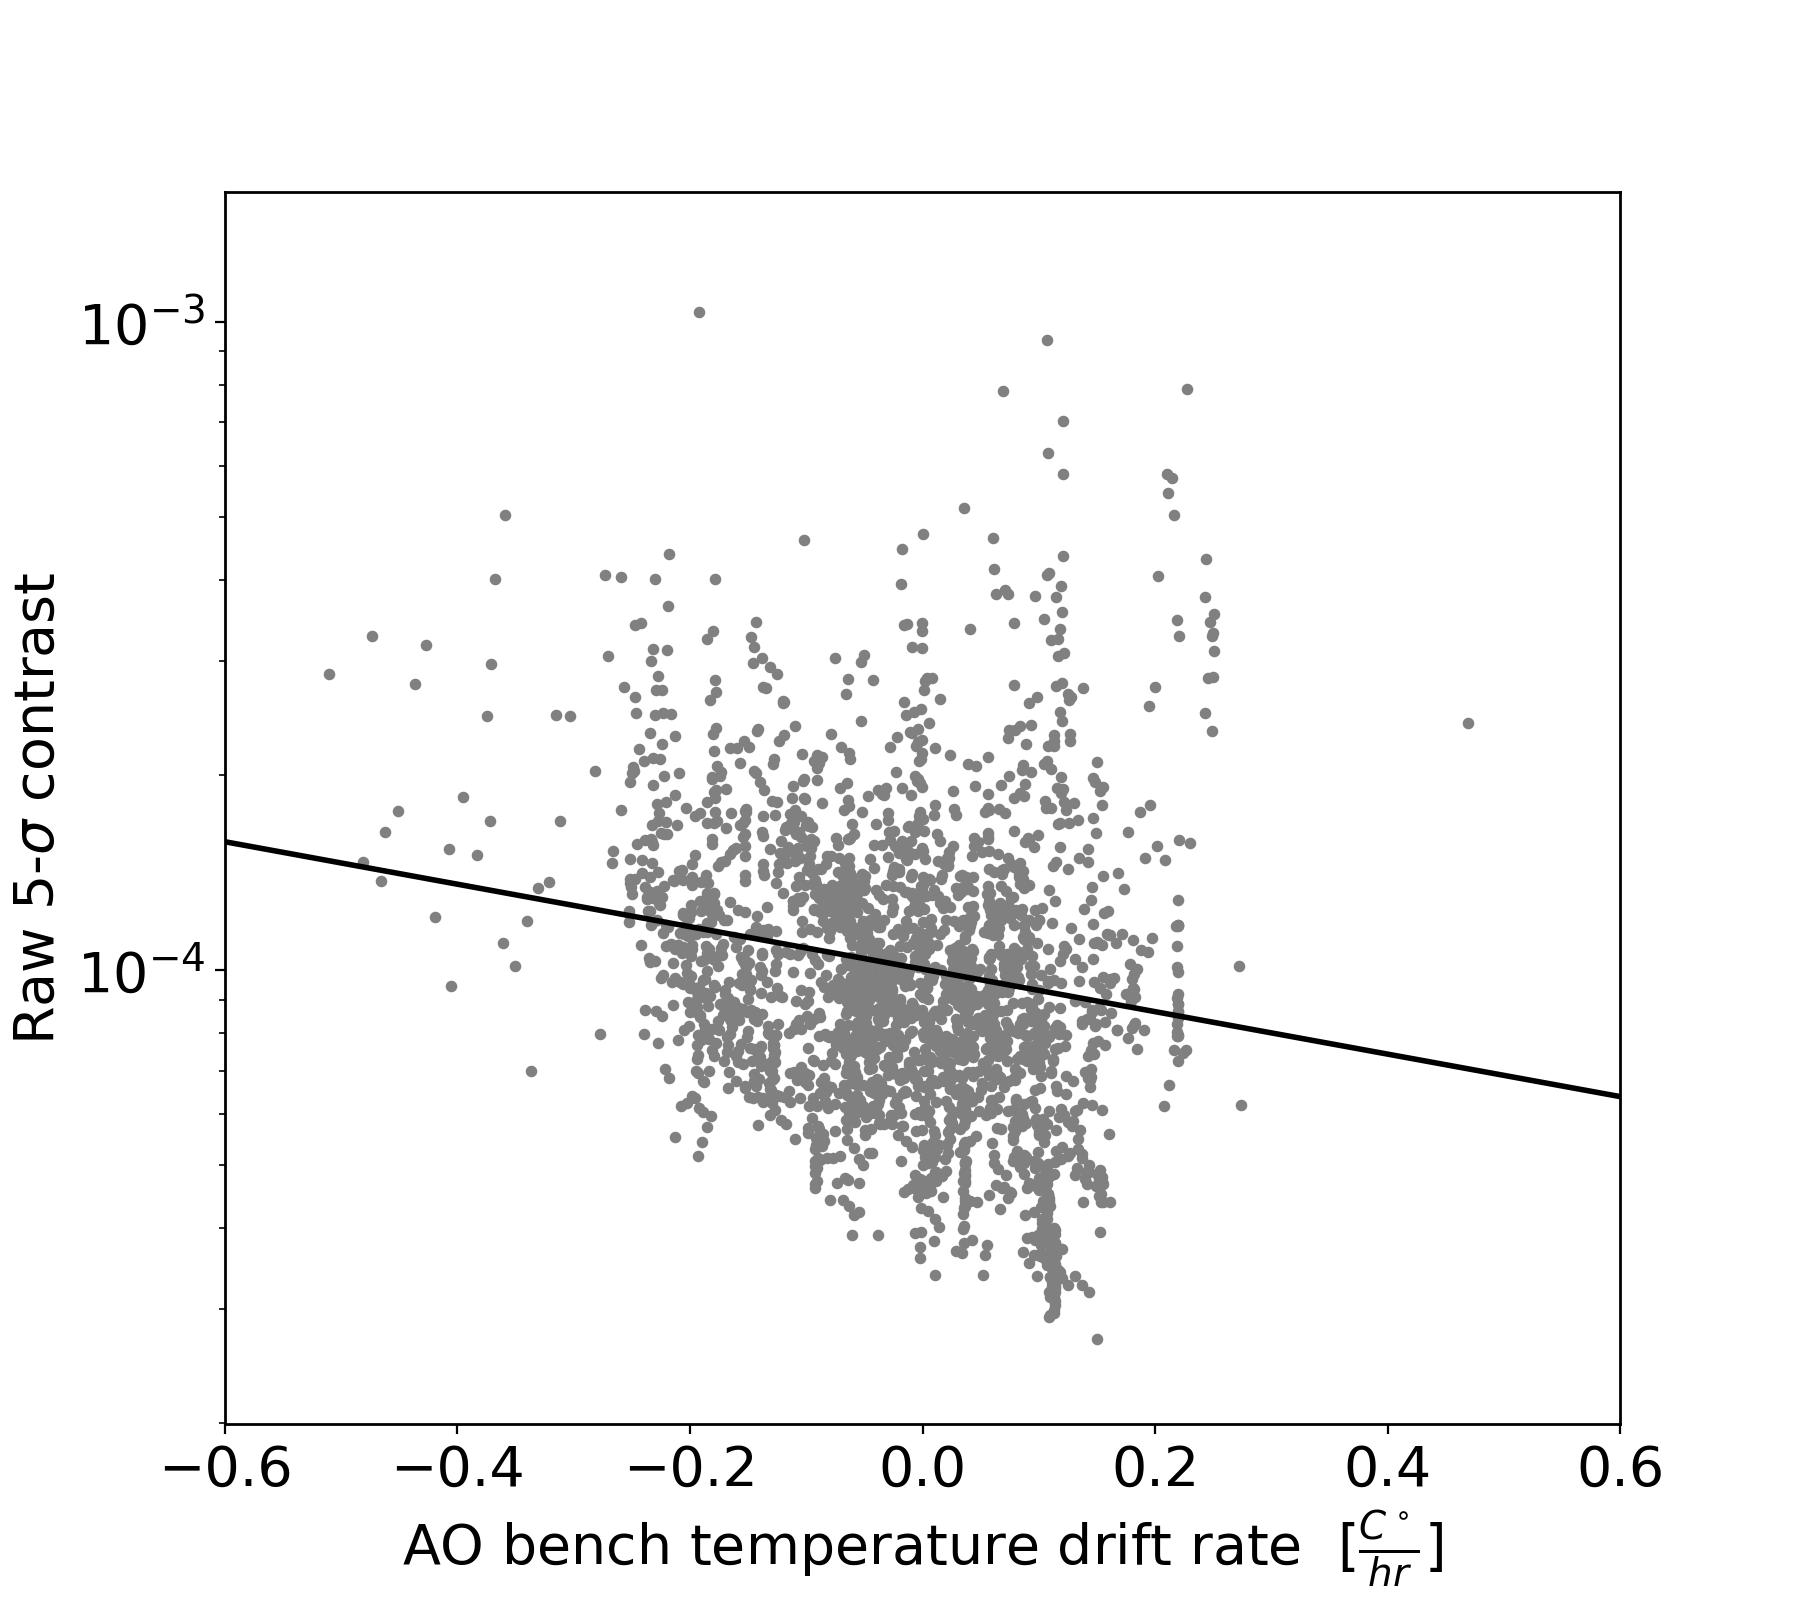

('slope: ', -0.32748246984618035)
('intercept: ', -3.998544607523472)
('r2: ', 0.03041236847362536)


In [67]:
%matplotlib notebook

fig,ax = plt.subplots(1,1,figsize = [9,8])
im = scatter_plot(ax,r,col ='grey',parval1 ='CONTR040',temp3 = 'OMSATEMP_dT')
fit = plot_linear_fit(ax,f,col='k', temp3='OMSATEMP_dT',parval = 'CONTR040')
#ax.set_ylim(-.5,.3)

plt.savefig(savedir+'raw_ao_bench_drift_'+dstr+'.png',dpi = 300)